In [3]:
import pandas as pd
import re
from gensim.models import FastText, Word2Vec
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import numpy as np
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import pickle
from nltk.stem.isri import ISRIStemmer

In [2]:
# Load the dataset
df = pd.read_csv('/Users/ahadm/Downloads/arabic_reviews.csv')
print(df.head())


      label                                               text
0  Positive  ممتاز. البوفيه المفتوح رائع جدا سواء في الفطور...
1  Negative  كتاب حكم النبي محمد الذي كتبه الأديب الروائي ا...
2  Positive  معلومات تاريخية عن الثورة الإيرانية وما حدث في...
3  Negative  جلال أمين لم يجد إجابه للسؤال، فأخد يسرد لنا ق...
4  Positive      شقة ممتازة . أعجبني كل شيء وخاصة طاقم العمل..


In [4]:
# Drop rows where 'text' is NaN
df.dropna(subset=['text'], inplace=True)


In [5]:
# Download Arabic stopwords
nltk.download('stopwords')

# Initialize the stemmer
stemmer = ISRIStemmer()

# Arabic stopwords list
arabic_stopwords = set(stopwords.words('arabic'))

# List of negation words
negation_words = {'لا', 'لم', 'لن', 'ما', 'ليس', 'بدون', 'غير'}

# Remove negation words from the stopwords list
arabic_stopwords = arabic_stopwords - negation_words

def preprocess_text(text):
    # 1. Remove diacritics
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    
    # 2. Normalize letters (e.g., ا, آ, إ -> ا)
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    
    # 3. Normalize the letter "ة" to "ه"
    text = re.sub(r'ة', 'ه', text)
    
    # 4. Remove non-Arabic characters (numbers, English letters, special symbols)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[^\u0621-\u064A\s]', '', text)
    
    # 5. Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1', text)

    # 6. Tokenize the text
    words = text.split()
    
    # 7. Remove stopwords (excluding negation words)
    words = [word for word in words if word not in arabic_stopwords]
    
    # 8. Apply stemming
    stemmed_words = [stemmer.stem(word) for word in words]

    # 9. Rejoin the words
    return ' '.join(stemmed_words)



[nltk_data] Downloading package stopwords to /Users/ahadm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Apply preprocessing to the text
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [8]:
# Tokenization
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

In [13]:
# Save the cleaned data
df.to_csv('/Users/ahadm/Documents/tokenized6_data.csv', index=False)

In [10]:
# TF-IDF Transformation
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

# Manual Features
negation_words = ['لا', 'لم', 'ليس', 'ما', 'لن', 'بدون', 'غير', 'لمّا']
recommendation_words = ['أنصح', 'اوصي', 'لا أنصح', 'تجنب', 'ابتعد عن']
positive_words = ['ممتازة', 'ممتاز', 'رائع', 'جيد', 'مذهل', 'أفضل', 'جميل', 'سريع', 'مميز']
negative_words = ['سيء', 'رديء', 'بطيء', 'تأخر', 'مزعج', 'ضعيف', 'غير مناسب', 'فشل']
comparison_words = ['أفضل من', 'أسوأ من', 'مقارنة بـ', 'أكبر من', 'أقل من']

def detect_negation(text):
    return sum(1 for neg_word in negation_words if neg_word in text)
    
def count_positive_words(text):
    return sum(1 for word in text.split() if word in positive_words)

def count_negative_words(text):
    return sum(1 for word in text.split() if word in negative_words)

def negative_positive_ratio(text):
    pos_count = count_positive_words(text)
    neg_count = count_negative_words(text)
    return neg_count / (pos_count + 1)

def count_recommendations(text):
    return sum(1 for word in recommendation_words if word in text)

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def detect_double_negation(text):
    if re.search(r'لا لم|ما ليس|ما لم يكن', text):
        return 1
    return 0

# Apply manual features
df['negation_count'] = df['cleaned_text'].apply(detect_negation)
df['recommendation_count'] = df['cleaned_text'].apply(count_recommendations)
df['polarity_score'] = df['cleaned_text'].apply(get_polarity)
df['positive_word_count'] = df['cleaned_text'].apply(count_positive_words)
df['negative_word_count'] = df['cleaned_text'].apply(count_negative_words)
df['neg_pos_ratio'] = df['cleaned_text'].apply(negative_positive_ratio)
df['comparison_count'] = df['cleaned_text'].apply(lambda x: sum(1 for word in comparison_words if word in x))
df['detect_double_negation'] = df['cleaned_text'].apply(detect_double_negation)

# Combine manual features with TF-IDF
handcrafted_features = df[['negation_count', 'recommendation_count', 'polarity_score', 'positive_word_count', 'negative_word_count', 'neg_pos_ratio', 'comparison_count', 'detect_double_negation']].values
X_combined = hstack([X, handcrafted_features])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_combined = imputer.fit_transform(X_combined)

# Feature Selection
selector = SelectKBest(chi2, k=1000)
X_selected = selector.fit_transform(X_combined, y)


In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Convert to DataFrame
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
# Using TF-IDF for training

In [ ]:
sample_size = 60000
X_train_df = X_train_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

if len(X_train_df) > sample_size:
    X_train_sample = X_train_df.sample(n=sample_size, random_state=42)
    y_train_sample = y_train.iloc[X_train_sample.index]
else:
    X_train_sample = X_train_df
    y_train_sample = y_train

clf = LazyClassifier(ignore_warnings=True, random_state=42)
models, predictions = clf.fit(X_train_sample, X_test_df, y_train_sample, y_test)
print(models)

In [35]:
# Train models (Extra Trees, LGBM, Ridge Classifier)
models = {
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'RidgeClassifier': RidgeClassifier()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

# Test new texts
new_texts = ["الخدمة كانت ممتازة وسريعة", "هذا الهاتف لا يستحق الشراء", "التجربة كانت سيئة جدًا"]
new_texts_cleaned = [preprocess_text(text) for text in new_texts]
new_texts_tfidf = vectorizer.transform(new_texts_cleaned)

for model_name, model in models.items():
    predictions = model.predict(new_texts_tfidf)
    print(f"\nModel {model_name} Results:")
    for text, pred in zip(new_texts, predictions):
        print(f"Text: {text}\nPredicted Label: {pred}\n")

[LightGBM] [Info] Number of positive: 26715, number of negative: 26617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387617
[LightGBM] [Info] Number of data points in the train set: 53332, number of used features: 4999
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500919 -> initscore=0.003675
[LightGBM] [Info] Start training from score 0.003675

نتائج نموذج ExtraTreesClassifier:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج LGBMClassifier:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج RidgeClassifi

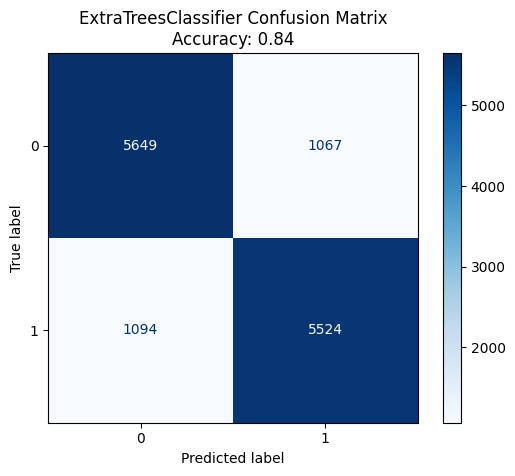

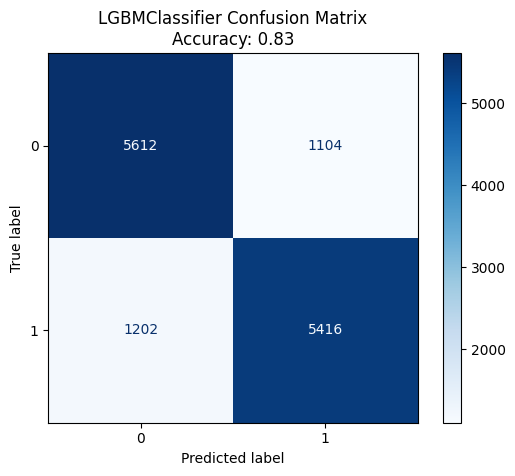

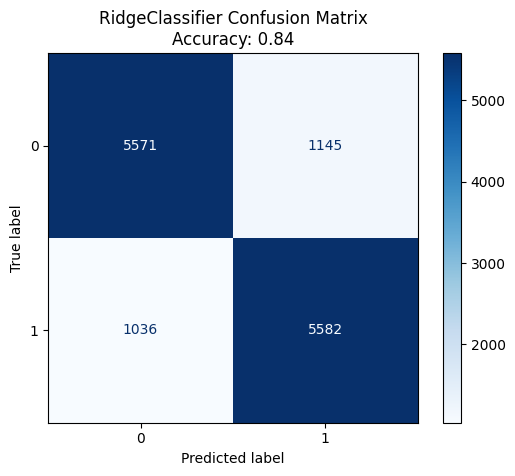

In [36]:
# Evaluate models on test set
for model_name, model in models.items():
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    
    plt.title(f"{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}")
    plt.show()

In [37]:
# Save Extra Trees model and TF-IDF vectorizer
with open('extratrees_model.pkl', 'wb') as model_file:
    pickle.dump(models['ExtraTreesClassifier'], model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [ ]:
# using Word2vec

In [13]:
# 1. Train the Word2Vec model
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=200, window=5, min_count=1, workers=4)

# 2. Convert the text to numerical representation using Word2Vec
def get_w2v_features(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_w2v = np.vstack(df['tokens'].apply(lambda x: get_w2v_features(x, w2v_model)))

# 3. Combine manual features with Word2Vec
X_combined_w2v = np.hstack([X_w2v, df[['negation_count', 'recommendation_count', 'polarity_score','positive_word_count','negative_word_count','neg_pos_ratio','comparison_count','detect_double_negation']].values])

# 4. Handle missing values
X_combined_w2v = SimpleImputer(strategy='mean').fit_transform(X_combined_w2v)

# 5. Select the best features 
X_selected_w2v = SelectKBest(mutual_info_classif, k=1000).fit_transform(X_combined_w2v, y)

# 6. Split the data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_selected_w2v, y, test_size=0.2, random_state=42)

# 7. Apply LazyPredict on the Word2Vec model
X_train_w2v_df = pd.DataFrame(X_train_w2v)
X_test_w2v_df = pd.DataFrame(X_test_w2v)

if len(X_train_w2v_df) > sample_size:
    X_train_sample_w2v = X_train_w2v_df.sample(n=sample_size, random_state=42)
    y_train_sample_w2v = y_train_w2v.iloc[X_train_sample_w2v.index]
else:
    X_train_sample_w2v = X_train_w2v_df
    y_train_sample_w2v = y_train_w2v

clf_w2v = LazyClassifier(ignore_warnings=True, random_state=42)
models_w2v, predictions_w2v = clf_w2v.fit(X_train_sample_w2v, X_test_w2v_df, y_train_sample_w2v, y_test_w2v)
print("Word2Vec Results:")
print(models_w2v)


 97%|█████████████████████████████████████████▋ | 31/32 [37:46<00:23, 23.33s/it]

[LightGBM] [Info] Number of positive: 26715, number of negative: 26617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51042
[LightGBM] [Info] Number of data points in the train set: 53332, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500919 -> initscore=0.003675
[LightGBM] [Info] Start training from score 0.003675


100%|███████████████████████████████████████████| 32/32 [37:48<00:00, 70.89s/it]

Word2Vec Results:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
SVC                                0.83               0.83    None      0.83   
NuSVC                              0.82               0.82    None      0.82   
LinearSVC                          0.81               0.81    None      0.81   
CalibratedClassifierCV             0.81               0.81    None      0.81   
LGBMClassifier                     0.81               0.81    None      0.81   
LogisticRegression                 0.81               0.81    None      0.81   
SGDClassifier                      0.81               0.81    None      0.81   
RidgeClassifierCV                  0.80               0.80    None      0.80   
RidgeClassifier                    0.80               0.80    None      0.80   
LinearDiscriminantAnalysis         0.80               0.80    None      0.80   
RandomForestClassifier

In [54]:
# Train the three models on Word2Vec data
models = {
    'SVC': SVC(random_state=42),
    'NuSVC': NuSVC(random_state=42),
    'LinearSVC': LinearSVC(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train_w2v, y_train)

# New texts for testing
new_texts = ["الخدمة كانت ممتازة وسريعة", "هذا الهاتف لا يستحق الشراء", "التجربة كانت سيئة جدًا"]
# Clean the new texts
new_texts_cleaned = [preprocess_text(text) for text in new_texts]

# Convert the texts to numerical representation using Word2Vec
def get_w2v_features(tokens, model, expected_features):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(model.vector_size)
    
    # Adjust the shape to ensure feature count matches
    mean_vector = np.resize(mean_vector, (expected_features,))
    
    return mean_vector

# Get the feature count from X_train_w2v
expected_features = X_train_w2v.shape[1]

new_texts_w2v = np.vstack([get_w2v_features(text.split(), w2v_model, expected_features) for text in new_texts_cleaned])

# Predict categories using each model
for model_name, model in models.items():
    predictions = model.predict(new_texts_w2v)
    print(f"\n{model_name} Model Results:")
    for text, pred in zip(new_texts, predictions):
        print(f"Text: {text}\nPredicted Category: {pred}\n")



نتائج نموذج SVC:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج NuSVC:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج LinearSVC:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative



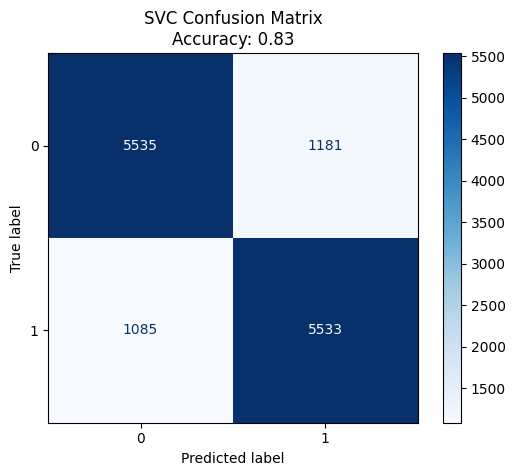

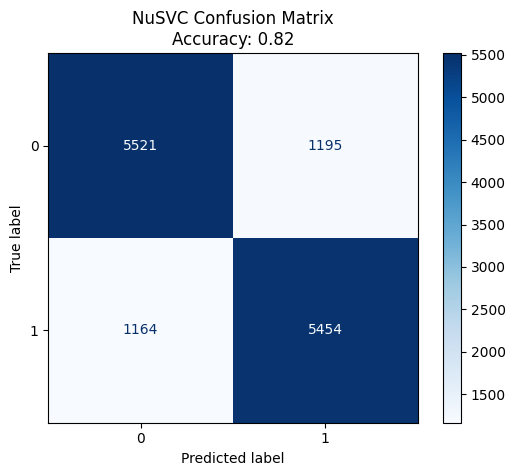

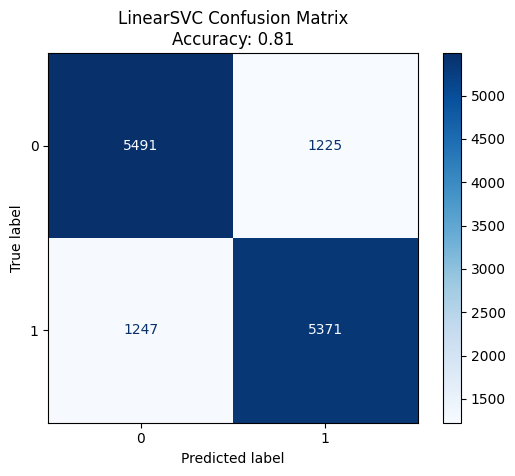

In [55]:
# Ensure X_test_w2v contains the same number of features as X_train_w2v
X_test_w2v = X_test_w2v[:, :X_train_w2v.shape[1]]

# Predict categories on the test data
for model_name, model in models.items():
    predictions = model.predict(X_test_w2v)
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)  # Calculate accuracy
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    
    # Add accuracy as a title
    plt.title(f"{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}")
    plt.show()

In [56]:
# Save the LinearSVC model
with open('linearsvc_model.pkl', 'wb') as model_file:
    pickle.dump(models['LinearSVC'], model_file)

# Save the Word2Vec model
with open('w2v_model.pkl', 'wb') as w2v_file:
    pickle.dump(w2v_model, w2v_file)

In [ ]:
# using FastText

In [14]:
# 1. Train the FastText model
fasttext_model = FastText(sentences=df['tokens'], vector_size=200, window=5, min_count=1, workers=4)

# 2. Convert the texts to numerical representation using FastText
def get_fasttext_features(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_fasttext = np.vstack(df['tokens'].apply(lambda x: get_fasttext_features(x, fasttext_model)))

# 3. Combine manual features with FastText
X_combined_fasttext = np.hstack([X_fasttext, df[['negation_count', 'recommendation_count', 'polarity_score','positive_word_count','negative_word_count','neg_pos_ratio','comparison_count','detect_double_negation']].values])

# 4. Handle missing values
X_combined_fasttext = SimpleImputer(strategy='mean').fit_transform(X_combined_fasttext)

# 5. Select the best features  
X_selected_fasttext = SelectKBest(mutual_info_classif, k=1000).fit_transform(X_combined_fasttext, y)

# 6. Split the data
X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(X_selected_fasttext, y, test_size=0.2, random_state=42)

# 7. Apply LazyPredict on the FastText model
X_train_fasttext_df = pd.DataFrame(X_train_fasttext)
X_test_fasttext_df = pd.DataFrame(X_test_fasttext)

if len(X_train_fasttext_df) > sample_size:
    X_train_sample_fasttext = X_train_fasttext_df.sample(n=sample_size, random_state=42)
    y_train_sample_fasttext = y_train_fasttext.iloc[X_train_sample_fasttext.index]
else:
    X_train_sample_fasttext = X_train_fasttext_df
    y_train_sample_fasttext = y_train_fasttext

clf_fasttext = LazyClassifier(ignore_warnings=True, random_state=42)
models_fasttext, predictions_fasttext = clf_fasttext.fit(X_train_sample_fasttext, X_test_fasttext_df, y_train_sample_fasttext, y_test_fasttext)
print("FastText Results:")
print(models_fasttext)

 97%|█████████████████████████████████████████▋ | 31/32 [40:08<00:24, 24.26s/it]

[LightGBM] [Info] Number of positive: 26715, number of negative: 26617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51042
[LightGBM] [Info] Number of data points in the train set: 53332, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500919 -> initscore=0.003675
[LightGBM] [Info] Start training from score 0.003675


100%|███████████████████████████████████████████| 32/32 [40:10<00:00, 75.32s/it]

FastText Results:
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
SVC                                0.83               0.83    None      0.83   
NuSVC                              0.82               0.82    None      0.82   
CalibratedClassifierCV             0.81               0.81    None      0.81   
LinearSVC                          0.81               0.81    None      0.81   
LGBMClassifier                     0.81               0.81    None      0.81   
LogisticRegression                 0.81               0.81    None      0.81   
RidgeClassifier                    0.80               0.80    None      0.80   
RidgeClassifierCV                  0.80               0.80    None      0.80   
LinearDiscriminantAnalysis         0.80               0.80    None      0.80   
ExtraTreesClassifier               0.80               0.80    None      0.80   
RandomForestClassifier

In [57]:
# Train the three models on FastText data
models = {
    'SVC': SVC(random_state=42),
    'NuSVC': NuSVC(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
}

for model_name, model in models.items():
    model.fit(X_train_fasttext, y_train)

# New texts for testing
new_texts = ["الخدمة كانت ممتازة وسريعة", "هذا الهاتف لا يستحق الشراء", "التجربة كانت سيئة جدًا"]

# Clean the new texts
new_texts_cleaned = [preprocess_text(text) for text in new_texts]

# Convert the texts to numerical representation using FastText
def get_fasttext_features(tokens, model, expected_features):
    vectors = [fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv]
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(model.vector_size)
    
    # Adjust the shape to ensure feature count matches
    mean_vector = np.resize(mean_vector, (expected_features,))
    
    return mean_vector

# Get the feature count from X_train_fasttext
expected_features = X_train_fasttext.shape[1]

new_texts_fasttext = np.vstack([get_fasttext_features(text.split(), fasttext_model, expected_features) for text in new_texts_cleaned])

# Predict categories using each model
for model_name, model in models.items():
    predictions = model.predict(new_texts_fasttext)
    print(f"\n{model_name} Model Results:")
    for text, pred in zip(new_texts, predictions):
        print(f"Text: {text}\nPredicted Category: {pred}\n")



نتائج نموذج SVC:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج NuSVC:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative


نتائج نموذج LogisticRegression:
النص: الخدمة كانت ممتازة وسريعة
التصنيف المتوقع: Positive

النص: هذا الهاتف لا يستحق الشراء
التصنيف المتوقع: Negative

النص: التجربة كانت سيئة جدًا
التصنيف المتوقع: Negative



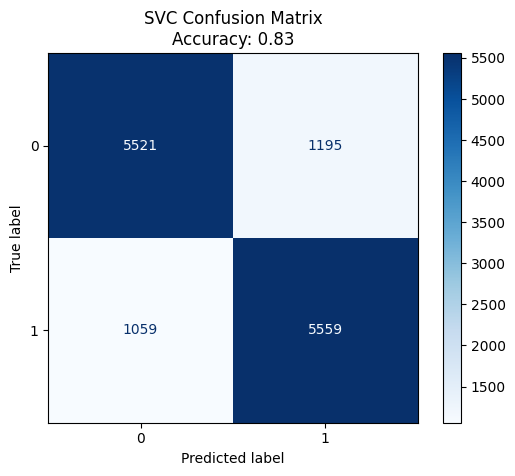

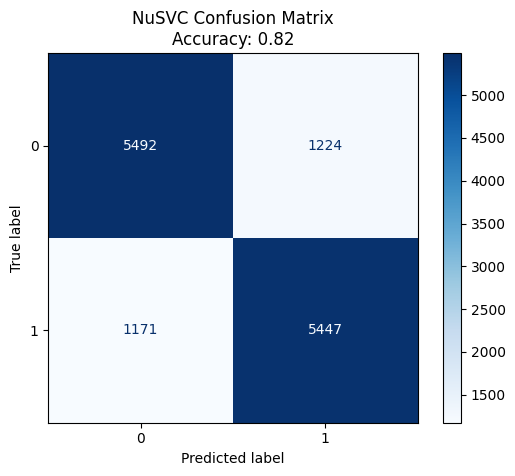

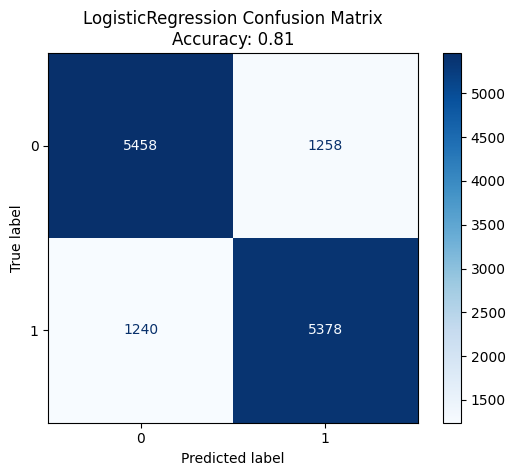

In [58]:
# Ensure X_test_fasttext contains the same number of features as X_train_fasttext
X_test_fasttext = X_test_fasttext[:, :X_train_fasttext.shape[1]]

# Predict categories on the test data
for model_name, model in models.items():
    predictions = model.predict(X_test_fasttext)
    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)  # Calculate accuracy
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    
    # Add accuracy as a title
    plt.title(f"{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}")
    plt.show()

In [59]:
# Save the SVC model
with open('fasttext_svc_model.pkl', 'wb') as model_file:
    pickle.dump(models['SVC'], model_file)

# Save the FastText model
with open('fasttext_model.pkl', 'wb') as ft_file:
    pickle.dump(fasttext_model, ft_file)